In [2]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np
import cv2
np.seterr(all='raise')

Populating the interactive namespace from numpy and matplotlib


In [24]:
def nd(l):
    return np.array(l,dtype=float)
def Vis(U):
# Visualizing A Cluster
    img=U/U.max()
    img=(img*255).astype(int)
    plt.imshow(img,cmap='gray')
    plt.show()
def VisCrisp(U):
    img=(U==numpy.amax(U,axis=(0)))*255
    for Map in img:
        Vis(Map)

In [4]:
import os
cwd = os.getcwd()
img = cv2.imread(cwd+'\\mri.jpg', cv2.IMREAD_GRAYSCALE)

In [5]:
img.shape

(100, 100)

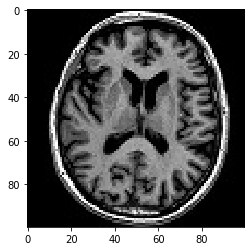

In [6]:
plt.imshow(img,cmap='gray')
plt.show()

In [7]:
def normalizeImage(img):
    minPx,maxPx=img.min(),img.max()
    NormalizedImg = (img-minPx)/(maxPx-minPx)
    return NormalizedImg

normImg=normalizeImage(img)

In [31]:
from scipy.signal import convolve2d
def conv(Mat,ngb):
    if(ngb==0):
        return np.zeros(Mat.shape)
    ngbhd=2*ngb+1
    Filter=np.ones((ngbhd, ngbhd))
    Filter[ngb,ngb]=0
    Filter/=ngbhd**2 - 1
    for i in range(Mat.shape[0]):
        Mat[i]=convolve2d(Mat[i], Filter, mode='same', boundary='fill', fillvalue=0)
    return Mat

In [32]:
def getVar(X):
    n=X.shape[1]*X.shape[2]
    mean=X.sum(axis=(1,2))/n
    Var=np.power(X-mean[:,np.newaxis,np.newaxis],2)
    return Var.sum(axis=(0,1,2))/n

def sugenoNeg(mu,b=0.7):
    return (1-mu)/(1+b*mu)

def randomVMatGen(clusters):
    #V is the Centroid matrix
    mu = np.random.rand(clusters)
    nu=sugenoNeg(mu)
    V=np.array([mu,nu,1-mu-nu])
    return V

def UpCen(U,K,x,Lambda,ngb):
    T1=K*x+Lambda*conv(K*x,ngb)
    T2=K+Lambda*conv(K,ngb)
    return ((U*T1).sum(axis=(1,2))) / ((U*T2).sum(axis=(1,2)))

def getCentroids(X,U,K,Lambda,c,m,ngb):
    #U=1-sugenoNeg(U)
    muS= UpCen(np.power(U,m),K,X[0],Lambda,ngb)
    nuS= UpCen(np.power(U,m),K,X[1],Lambda,ngb)
    piS= UpCen(np.power(U,m),K,X[2],Lambda,ngb)
    V = np.array([muS,nuS,piS])
    return V

def d2(X,Y):
    return (np.power(X-Y,2)).sum(axis=0)

def updateMatU(X,V,Var,Lambda,c,m,ngb):
    c=V.shape[1]
    D2=d2(X[:,np.newaxis,:,:],V[:,:,np.newaxis,np.newaxis])  
    K=np.exp(-D2/Var)
    U=1-K+Lambda*np.power(conv(1-K,ngb),m)
    U=np.power(U,-1/(m-1))
    U=U/U.sum(axis=0)
    return [U,K]

In [44]:
def fcm(mu,m=2,c=3,Lambda=0.01,ngb=0,e=0.000000001,maxIter=100000):
    nu=sugenoNeg(mu)
    X=np.array([mu,nu,1-mu-nu])
    Var=getVar(X)
    V=randomVMatGen(c)
    ind=1
    #while numpy.absolute(U[0]-U[1]).max() < e:
    while ind<100:
        if  ind>maxIter:
            break
        U,K=updateMatU(X,V,Var,Lambda,c,m,ngb)
        V=getCentroids(X,U,K,Lambda,c,m,ngb)
        ind+=1
    print(ind)
    for i in range(4):
        Vis(U[i])
    return U,V    

In [45]:
mu=normImg

100


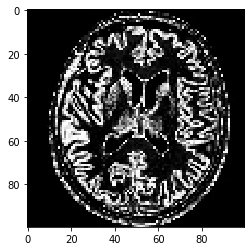

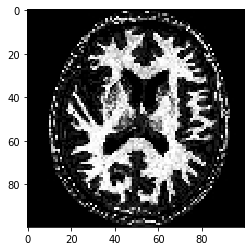

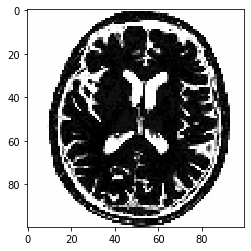

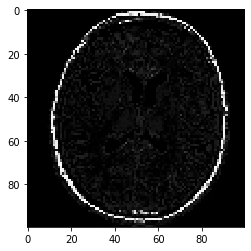

In [46]:
res=fcm(mu,c=4)

100


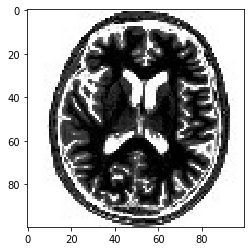

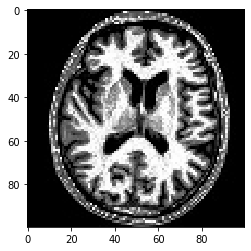

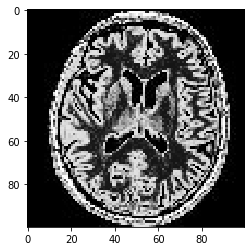

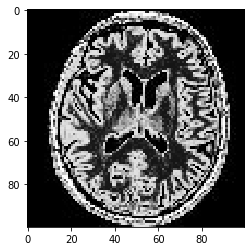

In [47]:
res=fcm(mu,c=4,ngb=1)

In [ ]:
def printImg(img):
    plt.imshow(img,cmap='gray')
    plt.show()
    
def GetImg(FileName):
    import os
    cwd = os.getcwd()
    img = cv2.imread(cwd+'\\Img\\'+FileName, cv2.IMREAD_GRAYSCALE)
    return img

def GetMap(U):
    Map=(U==numpy.amax(U,axis=(0))).astype(int)
    return Map

def GetGroundTurthMaps(FileName='NewImg2.tiff'):
    import os
    cwd = os.getcwd()
    img1 = GetImg(FileName)
    uniq=np.unique(img1)
    uniq.sort()
    Map=[]
    for i in range(uniq.size):
        Map.append(img1==uniq[i])
    return nd(Map),uniq,img1

def GetResMaps(res,getGrndTruth=0):
    img=GetImg('NewImg2.tiff')
    Maps=GetMap(res[0])
    Maps=nd(Maps)
    Avg=nd([(img*Map).sum()/Map.sum() for Map in Maps])
    Ord=numpy.argsort(Avg)
    Maps=Maps[Ord]
    #Maps=Maps*Inten[:,np.newaxis,np.newaxis] #To get the colored resultant
    return Maps

In [ ]:
def DiceScore(G,R):
    intersectionPx=2*(G*R).sum(axis=(1,2))
    return intersectionPx/(G+R).sum(axis=(1,2))
def AvgSegAcc(G,R):
    intersectionPx=(G*R).sum()
    return intersectionPx/G.sum()
def Scores(G,R):
    return DiceScore(G,R),AvgSegAcc(G,R)

def GetScores(FileName,G,printResMap=1):
    res=fcm(GetImg(FileName),maxIter=10)
    R=GetResMaps(res)
    if printResMap:
        for seg in R:
            printImg(seg)
    return Scores(G,R)

def GetAllImgScores(printResMap=0):
    import os
    path = os.getcwd()+'\\Img'
    Files=os.listdir(path)
    G,a,b=GetGroundTurthMaps()
    FilesScr={}
    for file in Files:
        FilesScr[file]=GetScores(file,G,printResMap)
        print(FilesScr[file])
    return FilesScr